# MNIST

In [2]:
# Import MNIST using sklearn
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape
y.shape

(70000,)

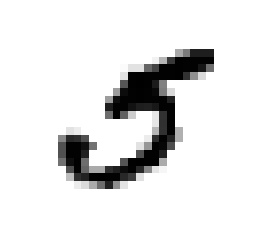

5.0

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()
y[36000]

In [12]:
# Split into training set and test set (with labels)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#Shuffle training set
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training a binary classifier

In [15]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

## Stochastic gradient descent classifier

In [17]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [18]:
sgd_clf.predict([some_digit]) # accurately predicts that some_digit is a 5.

array([ True], dtype=bool)

# Implementing cross-validation from scratch

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


#     clone_clf = clone(sgd_clf)

0.9635
0.96955
0.9645


## K-fold cross-validation

In [27]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9635 ,  0.96955,  0.9645 ])

## classify "not-5" to show why accuracy is not a preferred performance metric

In [35]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [44]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
never_5_pred = never_5_clf.predict(X_train)

# Confusion matrix

In [38]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [39]:
# get confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53721,   858],
       [ 1191,  4230]])

## Precision and Recall

In [48]:
from sklearn.metrics import precision_score, recall_score

print("precision:", precision_score(y_train_5, y_train_pred), "Recall:", recall_score(y_train_5, y_train_pred))

precision: 0.831367924528 Recall: 0.780298837853


In [49]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.80502426491578638

## Move decision boundary

In [50]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 36547.99613341])

In [52]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True], dtype=bool)

In [55]:
threshold = 37000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

In [71]:
# Use cross_val_predict, but now get the decision scores instead of prediction
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                             method="decision_function")

# Now compute the precision oand recall for all possible
# thresholds using precision_recall_curve()
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, 
                                                         y_scores)

# Now plot the precision and recall as a function of the threshold value
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(20, 10))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
def plot_precision_vs_recall(precisions, recalls):
    plt.figure(figsize=(20, 10))
    plt.plot(recalls[:-1], precisions[:-1], "b--", label="Precision")
    plt.xlabel("Recall")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

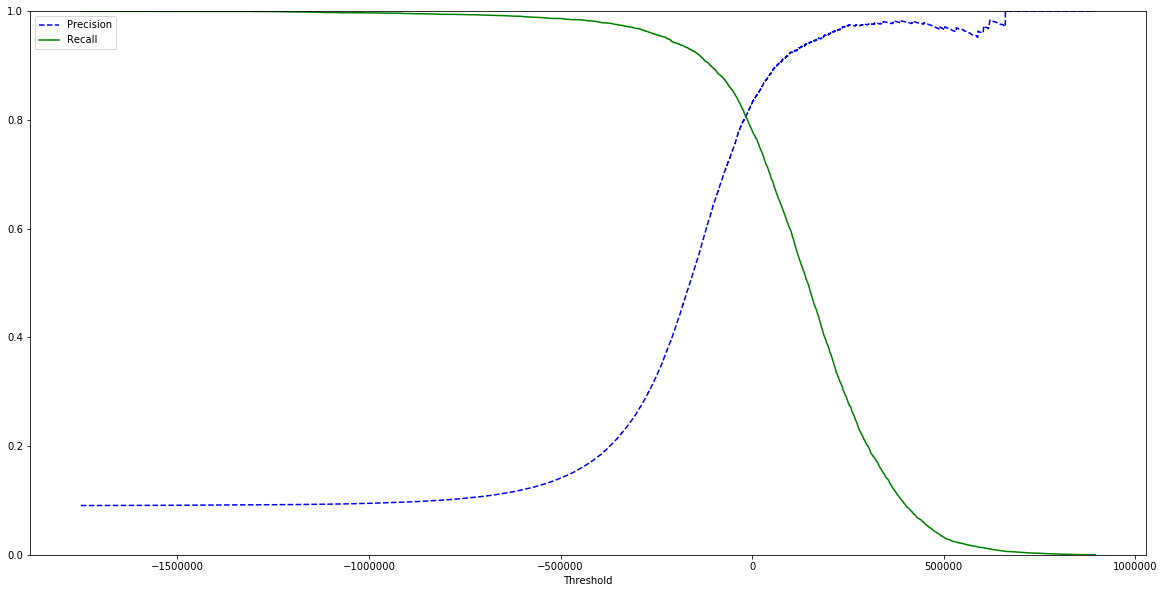

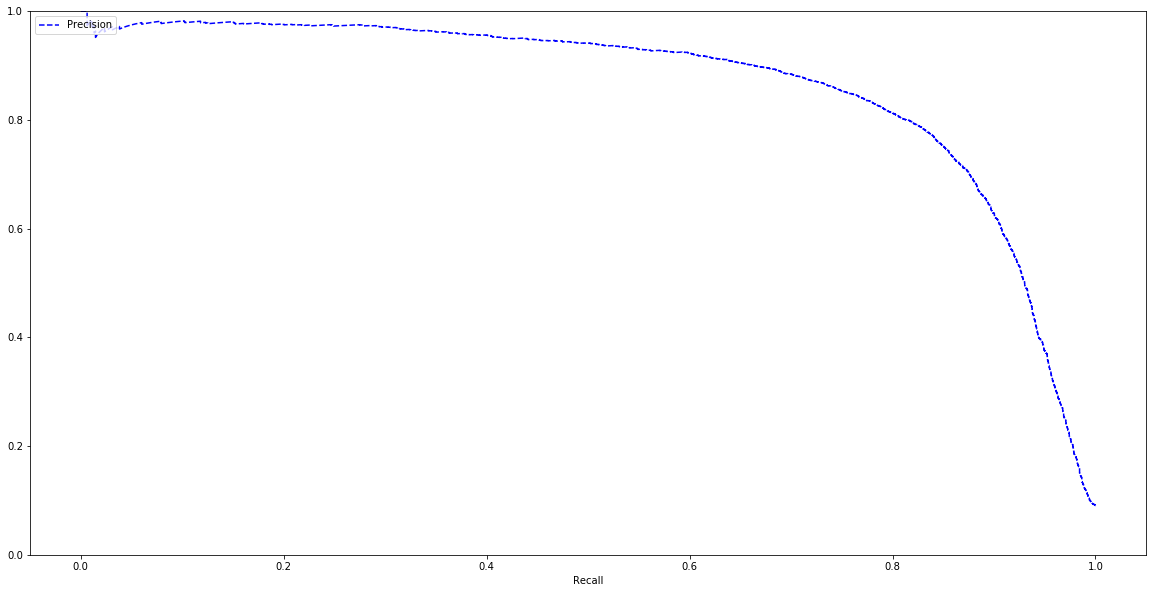

In [72]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
plt.figure()
plot_precision_vs_recall(precisions, recalls)
plt.show()